# Movie Recommendation Systems

![title](image3.png)

The purpose of this kernel is to build a recommendation engine for movies.Recommender System seeks to predict or filter preferences according to the user’s choices. Recommender systems are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags, and products in general. 
I have worked on the TMDB 5000 Movies dataset . The link is: https://www.kaggle.com/tmdb/tmdb-movie-metadata. For collaborative filtering, I have used data from movielens dataset of 10000 movies. The link is https://grouplens.org/datasets/movielens/latest/. We will clean data, analyse relevant variables and build the following 3 kinds of recommenders:
    1. Simple recommender
    2. Recommender based on content-based filtering
    3. Recommender based on collaborative filtering

#### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

#### Reading data and loading columns

 As the data in columns:-'genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages' are in json format, we can apply json.loads in order to access them.

In [3]:
def load_tmdb_movies(path):
    df=pd.read_csv(path)
    df['release_date']=pd.to_datetime(df['release_date']).apply(lambda x:x.date())
    json_columns= ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for col in json_columns:
        df[col]=df[col].apply(json.loads)
    return df

In [4]:
movies= load_tmdb_movies('C:\\Users\\vsinha\\Desktop\\tanu project\\tmdb-movie-metadata\\tmdb_5000_movies.csv')

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [6]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


We need to apply json loads to cast and crew columns in credits data as well. 

In [7]:
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [8]:
credits = load_tmdb_credits('C:\\Users\\vsinha\\Desktop\\tanu project\\tmdb-movie-metadata\\tmdb_5000_credits.csv')


#### Extracting Directors, lead casts , keywords and genres

In [9]:
movies=movies.merge(credits, left_on='id', right_on='movie_id')

In [10]:
movies=movies.rename(columns={'title_x': 'title'})
movies=movies.drop('title_y', axis=1)


In [11]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [12]:
movies['director'] = movies['crew'].apply(get_director)

In [13]:
# Returns the list top 3 elements or entire list; whichever is more. We will use this function to extract  lead actors, keywords and genres
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [14]:
movies['cast-lead_actors']=movies['cast'].apply(get_list)

In [15]:
movies['keywords']=movies['keywords'].apply(get_list)

In [16]:
movies['genres']=movies['genres'].apply(get_list)

#### Genres

Let's explore this variable to analyse the counts and the movies that figure in each category.

In [17]:
movies['genres'].head()

0            [Action, Adventure, Fantasy]
1            [Adventure, Fantasy, Action]
2              [Action, Adventure, Crime]
3                  [Action, Crime, Drama]
4    [Action, Adventure, Science Fiction]
Name: genres, dtype: object

(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 6 Text yticklabel objects>)

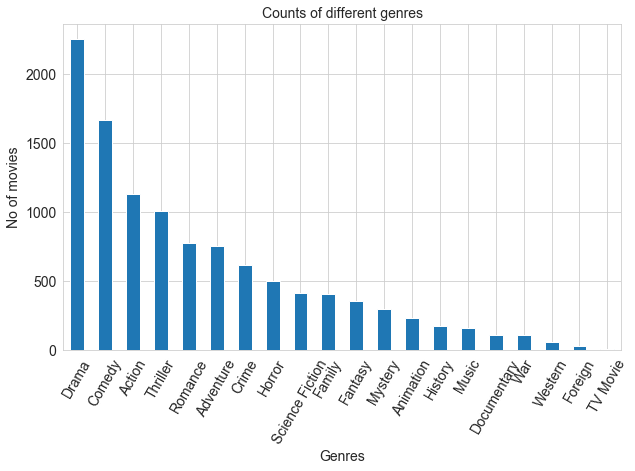

In [18]:
plt.figure(figsize=(10,6))
movies['genres'].apply(pd.Series).stack().reset_index(drop=True).value_counts().plot(kind='bar')
plt.xlabel('Genres',fontsize=14)
plt.ylabel('No of movies',fontsize=14)
plt.title('Counts of different genres',fontsize=14)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)

Most of the movies  listed on TMDB are from the Drama, Action and Comedy genres.

In [19]:
# dropping bad id's(movies in foreign language)
movies=movies.drop([4790, 3191,2294], axis=0)

Now, we can create a movies chart for each genres.

In [20]:
genres_list=movies['genres'].apply(pd.Series).stack().reset_index(drop=True).value_counts().index.to_list()

In [21]:
dflist=[]
for genres in genres_list:

    df=movies[movies['genres'].apply(lambda x : genres in x)][['original_title', 'popularity']].sort_values(by='popularity', ascending=False).head(10)
    df['genres']=genres
    dflist.append(df)


In [22]:
genres=pd.concat(dflist, axis=0)


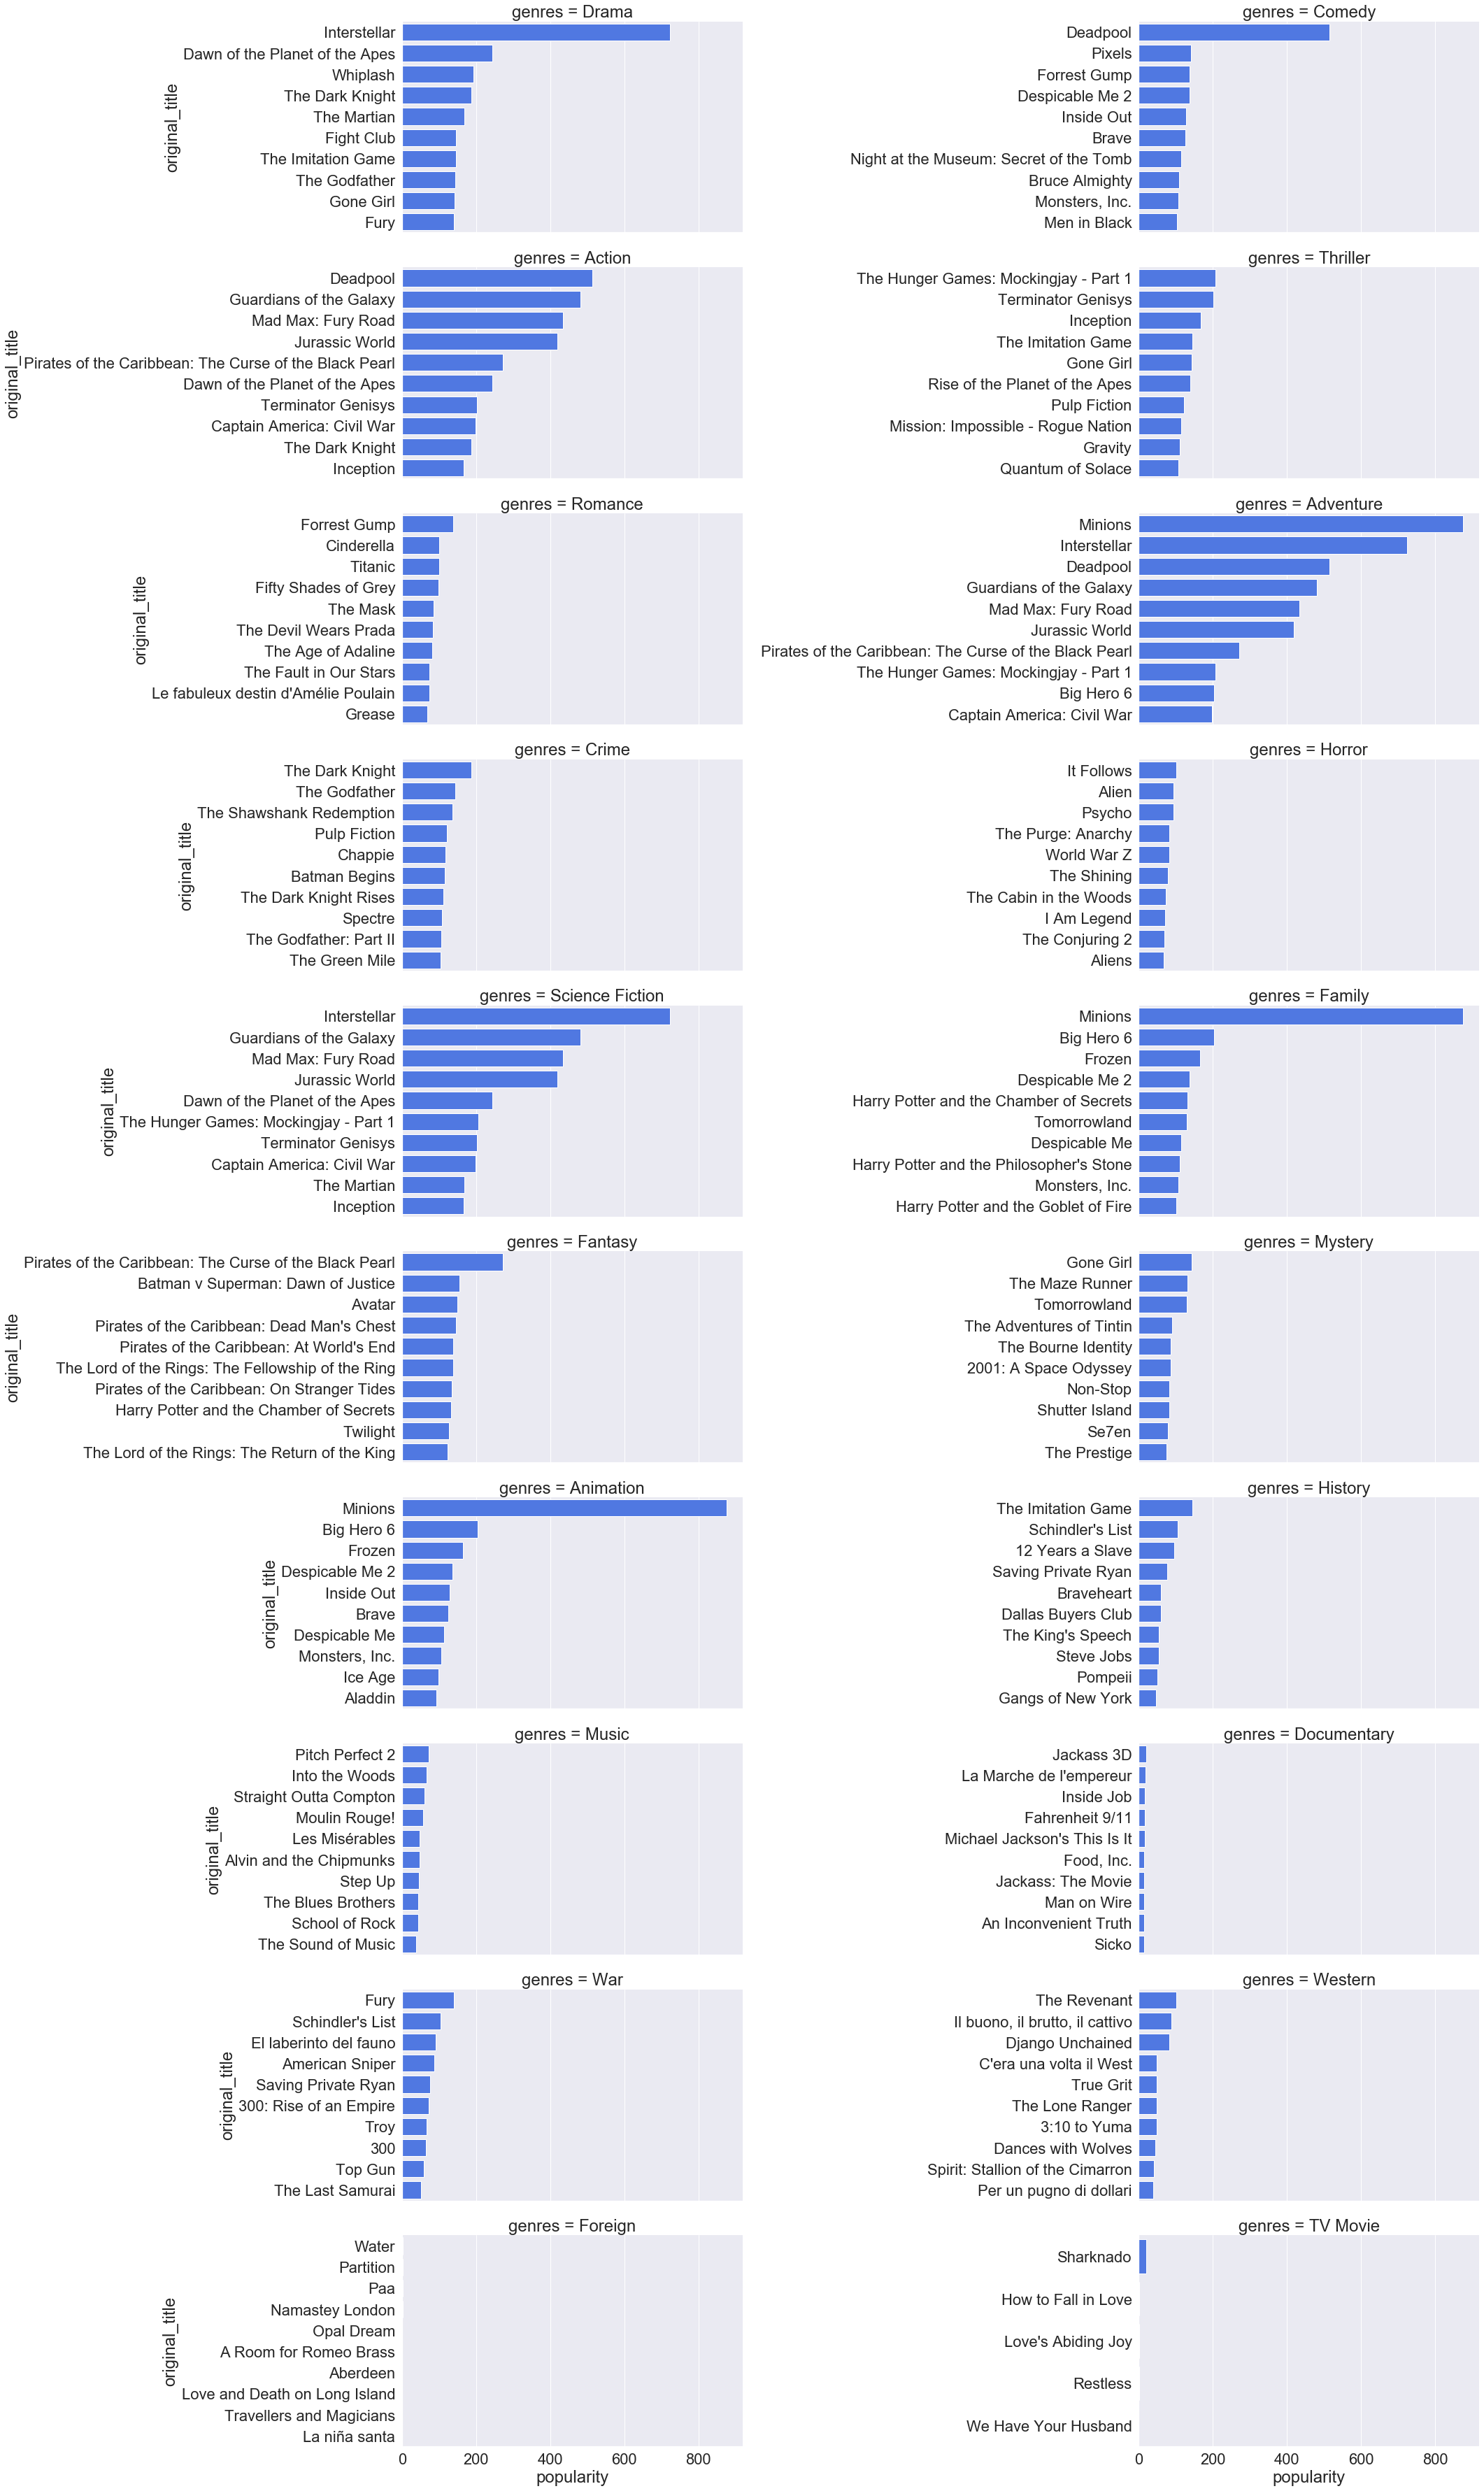

In [23]:
sns.set(context='notebook',
    style='darkgrid',
    palette='rainbow',font_scale=2)  
g = sns.FacetGrid(genres, col='genres', col_wrap=2, sharey=False, height=5, aspect=3 )
g.map(sns.barplot, 'popularity', 'original_title')


This variable describes the movies and differentiates it into distinct groups. Selection of movies based on genres also gives an idea about the tastes of viewers. 
Action, Adventure and Sci-fi movies have high popularity compared to other genres.

#### Movies with visual-effects

A lot of deparments are involved in movie production. When it comes to making movies visually appealing, there is a dedicated deparment with specialised function. Let's first extract all the departments and create a category for visual-effects. Then we can get movies that appear in this category.

In [24]:
#Creating a column for all the departments involved in movie production
movies['crew_dept']=movies['crew'].apply(lambda x: list(set([dict['department'] for dict in x])))



In [25]:
#  value_counts of all departments
movies['crew_dept'].apply(pd.Series).stack().reset_index(drop=True).value_counts()

Directing            4770
Writing              4577
Production           3923
Sound                3642
Editing              3582
Camera               3551
Art                  2995
Costume & Make-Up    2608
Crew                 1990
Visual Effects       1280
Lighting              894
Actors                  3
dtype: int64

1281 movies that were produced did have a dedicated deparment for visual-effects. Let's check out the most popular movies here.

In [26]:
visual=movies[movies['crew_dept'].apply(lambda x: 'Visual Effects'  in x )]

In [27]:
len(visual)

1280

In [28]:
visual.sort_values(by='popularity', ascending=False)[['original_title']].head(10)

,original_title
546,Minions
95,Interstellar
788,Deadpool
94,Guardians of the Galaxy
127,Mad Max: Fury Road
28,Jurassic World
199,Pirates of the Caribbean: The Curse of the Bla...
82,Dawn of the Planet of the Apes
200,The Hunger Games: Mockingjay - Part 1
88,Big Hero 6


#### Vote Average

In [29]:
movies['vote_average'].describe()

count    4800.000000
mean        6.091812
std         1.194452
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

Minimum vote_average is 1 and maximum is 10. Let's take a look at the histogram.

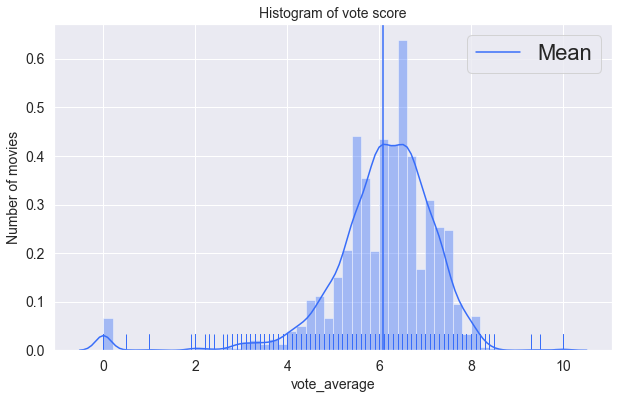

In [30]:
plt.figure(figsize=(10,6))
sns.distplot(movies['vote_average'], kde=True,rug=True,bins=50)
plt.axvline(movies['vote_average'].mean(), label='Mean')
plt.ylabel('Number of movies',fontsize=14)
plt.xlabel('vote_average',fontsize=14)
plt.title('Histogram of vote score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

In [31]:
print('The mean vote_average is {}'.format(round(movies['vote_average'].mean(),2)))

The mean vote_average is 6.09


This is bimodal and left- skewed distribution, There are only handful of movies that have a vote average of more that 8 .

In [32]:
#Let's take a look at top 10 movies as per vote_average
movies.sort_values(by='vote_average', ascending=False)[['original_title', 'vote_count', 'vote_average']].head(10)

,original_title,vote_count,vote_average
4045,"Dancer, Texas Pop. 81",1,10.0
4662,Little Big Top,1,10.0
3519,Stiff Upper Lips,1,10.0
4247,Me You and Five Bucks,2,10.0
3992,Sardaarji,2,9.5
2386,One Man's Hero,2,9.3
1881,The Shawshank Redemption,8205,8.5
2970,There Goes My Baby,2,8.5
3337,The Godfather,5893,8.4
2796,The Prisoner of Zenda,11,8.4


As seen from above, vote_average in itself is not  reliable as many movies have been voted high in single votes. We need to take into account the vote_count as well.

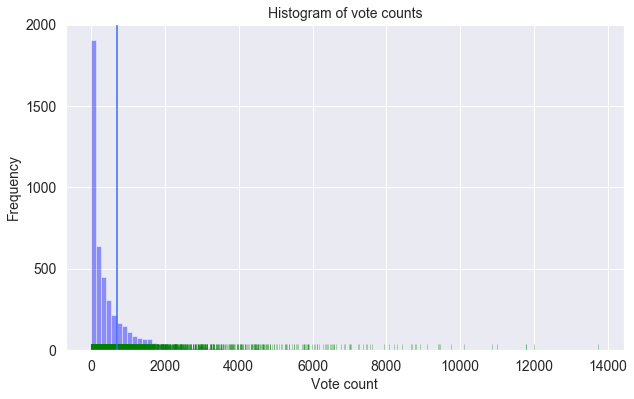

In [33]:
plt.figure(figsize=(10,6))
sns.distplot(movies['vote_count'], kde=False,rug=True,rug_kws={'height': .02, 'alpha': .3, 'color':'green'},color='blue',bins=100)
plt.title('Histogram of vote counts', fontsize=14)
plt.xlabel('Vote count',fontsize=14 )
plt.ylabel('Frequency',fontsize=14 )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(movies['vote_count'].mean(), label='Mean')

As seen, vote count is exponentially distributed. There are a number of movies with more than 2000 vote_count.

In [34]:
# Let's now take a look at the top 10 movies as per vote_count
movies.sort_values(by='vote_count', ascending=False)[['original_title', 'vote_count', 'vote_average']].head(10)

,original_title,vote_count,vote_average
96,Inception,13752,8.1
65,The Dark Knight,12002,8.2
0,Avatar,11800,7.2
16,The Avengers,11776,7.4
788,Deadpool,10995,7.4
95,Interstellar,10867,8.1
287,Django Unchained,10099,7.8
94,Guardians of the Galaxy,9742,7.9
426,The Hunger Games,9455,6.9
127,Mad Max: Fury Road,9427,7.2


Highest vote_count is 13700. When we see this chart, it's clear that vote_average is more reliable when vote_counts also figure in.

There are many thousands of movies and it is desired that one gets more relevant choices to pick from. 'Most watched movies' relate to their ratings and descriptions which represent a cumulative view of many people. So we can have a benchmark in votecounts.

In [35]:
np.percentile(movies['vote_count'], 90)

1832.800000000003

In [36]:
len(movies[movies['vote_count']> 1832])

480

If we take the 90th percentile as a benchmark, we get the vote_count of 1832 and there are some 480 movies that qualify for it.

#### Popularity

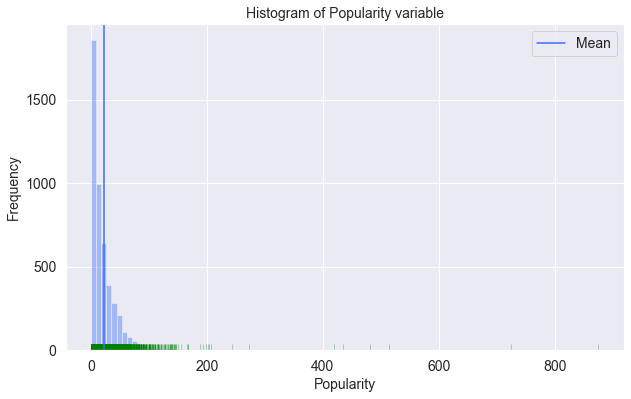

In [37]:
plt.figure(figsize=(10,6))
sns.distplot(movies['popularity'], kde=False,rug=True,rug_kws={'height': .02, 'alpha': .3, 'color':'green'}, bins=100)
plt.axvline(movies['popularity'].mean(), label='Mean')
plt.title('Histogram of Popularity variable', fontsize=14)
plt.xlabel('Popularity',fontsize=14 )
plt.ylabel('Frequency',fontsize=14 )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

This variable is exponentially distributed.
There are huge number of movies with very low popularity.
Movies that can be recommended are in top percentile/quartile of popularity. In the top percentile there are select movies in the range above popularity of 200.

In [38]:
print('The mean popularity is {}'.format(round(movies['popularity'].mean(),2)))


The mean popularity is 21.48


# Simple Recommenders

#### Simple recommender based on popularity

Popularity is a very important metric here on TMDb. It helps us boost search results, adds an incredibly useful sort value for discover, and is also just kind of fun to see items chart up and down. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

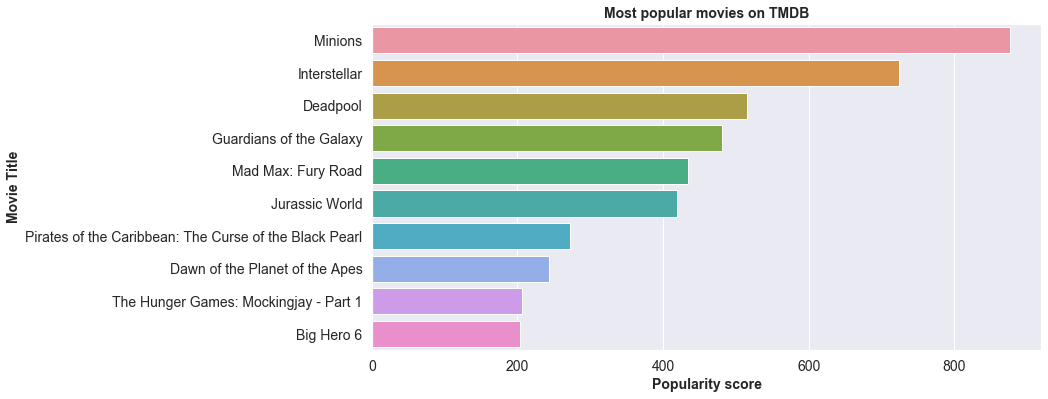

In [39]:

popular=movies.sort_values(by='popularity', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=popular['popularity'].head(10), y=popular['original_title'].head(10))
plt.title('Most popular movies on TMDB', weight='bold', fontsize=14)
plt.xlabel('Popularity score', weight='bold',fontsize=14)
plt.ylabel('Movie Title', weight='bold',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Popularity can be a reliable measure for selecting movies to watch. If this single metric is applied, its would generate the same recommendation for all viewers, irrespective of their individual preferences. And as their are only handful of movies in popularity range of 200 to 800, its highly probable that these movies would have been already watched.

#### Simple Recommender based on weighted vote average


A movie might have a high vote_average but very few might have watched it. So we need to factor the vote_count to get better idea. Further, we also factor a benchmark for a minimum vote_count to get listed in the Top 250(currently 3000). I will use IMDB's weighted rating formula to construct. 

The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed in the Top 250 

C = the mean vote across the whole report (currently 7.0)

For the Top 250, only votes from regular voters are considered.

In [40]:

v=movies['vote_count']
R=movies['vote_average']
C=movies['vote_average'].mean()
m=movies['vote_count'].quantile(.95)
movies['wtd_vote_average']=(v/(v+m)*R) + (m/(m+v) *C)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

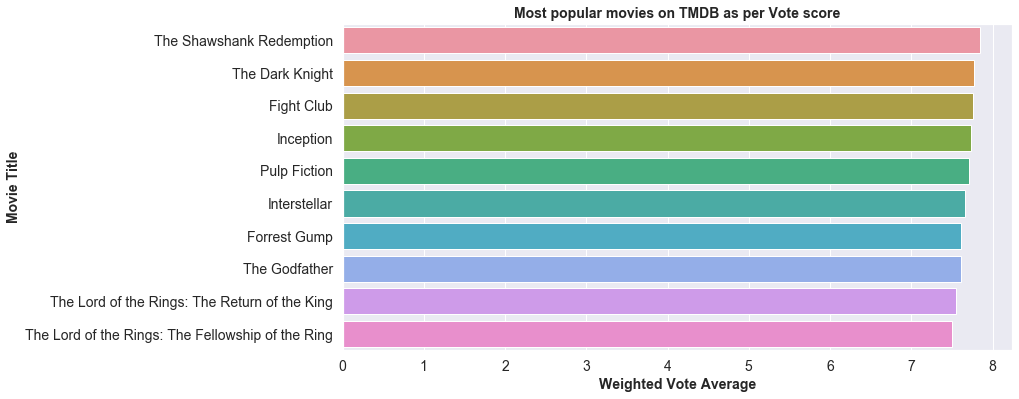

In [41]:

vote_score=movies.sort_values(by='wtd_vote_average', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=vote_score['wtd_vote_average'].head(10), y=vote_score['original_title'].head(10), data=vote_score)
plt.title('Most popular movies on TMDB as per Vote score', weight='bold',fontsize=14)
plt.xlabel('Weighted Vote Average', weight='bold',fontsize=14)
plt.ylabel('Movie Title', weight='bold',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Content Based Filtering

Content-based recommenders use item features to recommend other items similar to what the user likes. They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it.

Here I am going to build a recommender after computing the similarities between movies.Thus, this recommender would suggest movies similar to a particular movie that a viewer selects.

I will build two Content Based Recommenders based on:

1. Movie Overviews/descriptions.
    

2. Movie Cast, Crew, Keywords and Genres.
                                                           

### Recommendation based on descriptions

We will pass all the movie descriptions in 'overview' column to TfidfVectorizer, convert it into an item-item matrix and compute cosine similarities. 
The goal of using tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
tfidf=TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1,2), min_df=0) 

In [44]:
movies['overview']=movies['overview'].fillna(" ")

In [45]:
tfidf_matrix=tfidf.fit_transform(movies['overview'])

In [46]:
tfidf_matrix.shape

(4800, 136903)

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [47]:
from sklearn.metrics.pairwise import linear_kernel

In [48]:
#index of this matrix matches with the index of original series i.e movies['overview']
cosine_sim=linear_kernel(tfidf_matrix, tfidf_matrix)

In [49]:
indices=pd.Series(movies.index, index=movies['original_title']).drop_duplicates()


We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 10 most similar movies based on the cosine similarity score 

In [50]:

def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx=indices[title]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores=list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores=sorted(sim_scores, key=lambda x: x[1], reverse=True)
     # Get the scores of the 10 most similar movies
    sim_scores=sim_scores[1:11] #at 0 it is the title itself with sim_score=1
    # Get the movie indices
    movie_indices=[ele[0] for ele in sim_scores]
    # Return the top 10 most similar movies
    return movies['original_title'].iloc[movie_indices]
    

In [51]:
get_recommendations('The Dark Knight Rises')


299                              Batman Forever
65                              The Dark Knight
1359                                     Batman
428                              Batman Returns
2507                                  Slow Burn
119                               Batman Begins
3854    Batman: The Dark Knight Returns, Part 2
1181                                        JFK
210                              Batman & Robin
9            Batman v Superman: Dawn of Justice
Name: original_title, dtype: object

This recommender lasted down all Batman movies for Darknight Rises. Similarly, all the parts of GodFather will be suggested together. The problem here is that there could be movies that are not ranked high. Further this recommender misses the class of categories such as same Director / same Cast. 

### Recommendation based on likes of director or cast

We would combine the features of keywords, genres, director and lead actor and pass it to a word vectorizer. Attempt her is to improve the recommender  that would suggest movies of the same make i.e the same director or lead cast or genres.

In [52]:
# Function to convert all strings to lower case and strip names of spaces (to avoid duplication)
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        

In [53]:
features = ['cast-lead_actors', 'keywords', 'director', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [54]:
# adding director 3 times to add more weight

In [55]:
movies['director'] = movies['director'].apply(lambda x: [x,x, x])

You are now in a position to create your "metadata soup", which is a string that contains all the metadata that you want to feed to your vectorizer (namely actors, director and keywords).


In [56]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast-lead_actors']) + ' ' + ' '.join(x['director']) + ' ' + ' '.join(x['genres'])

In [57]:
movies['soup'] = movies.apply(create_soup, axis=1)

In [58]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [59]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [60]:
def get_genresrecommendations(title, cosine_sim2):
    # Get the index of the movie that matches the title
    idx=indices[title]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores=list(enumerate(cosine_sim2[idx]))
    # Sort the movies based on the similarity scores
    sim_scores=sorted(sim_scores, key=lambda x: x[1], reverse=True)
     # Get the scores of the 10 most similar movies
    sim_scores=sim_scores #at 0 it is the title itself with sim_score=1
    # Get the movie indices
    movie_indices=[ele[0] for ele in sim_scores]
    #movie_averages=sorted(list(movies['wtd_vote_average'].loc[movie_indices]),reverse=True)[0:10]
    movie_averages=sorted([(idx, movies['wtd_vote_average'].loc[idx]) for idx in movie_indices[0:30] ], key= lambda x : x[1], reverse=True)
    movie_indices=[ele[0] for ele in movie_averages][0:10]
    # Return the top 10 most similar movies
    return movies[['original_title','wtd_vote_average']].iloc[movie_indices]



In [61]:
contentrec2=get_genresrecommendations('The Dark Knight', cosine_sim2)
contentrec2.to_excel('contentrec2.xlsx')

In [62]:
movies.to_csv('C:\\Users\\vsinha\\Desktop\\tanu project\\ml-latest-small\\ml-latest-small\\mod_movies.csv')

## Collaborative Filtering

![title](image2.png)


Collaborative filtering methods are based on collecting and analyzing a large amount of information on user behaviors, activities or preferences and predicting what users will like based on their similarity to other users.
The fundamental assumption behind collaborative filtering technique is that similar user preferences over the items could be exploited to recommend those items to a user who has not seen or used it before. In simpler terms, we assume that users who agreed in the past (purchased the same product or viewed the same movie) will agree in the future.

We will build recommenders based on collaborative filtering for movies using data from movielens dataset. The link is https://grouplens.org/datasets/movielens/latest/.

In [63]:
ratings=pd.read_csv('ratings.csv')

In [64]:
links=pd.read_csv('links.csv')

In [65]:
movies=pd.read_csv('movies.csv')

In [66]:
tags=pd.read_csv('tags.csv')

In [67]:
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [68]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [69]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [70]:
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


### Ratings

(array([    0., 10000., 20000., 30000.]),
 <a list of 4 Text yticklabel objects>)

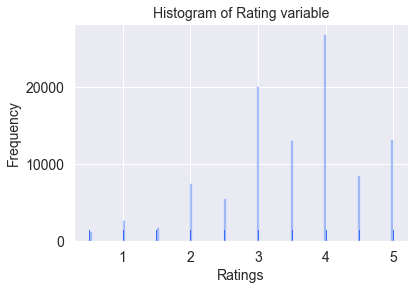

In [71]:
sns.distplot(ratings['rating'],kde=False, rug=True,bins=100)

plt.title('Histogram of Rating variable', fontsize=14)
plt.xlabel('Ratings',fontsize=14 )
plt.ylabel('Frequency',fontsize=14 )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


Ratings has discrete values.  Rating 4 is most frequently given by viewers, followed by 3 and 5.

__User-wise mean ratings.__

In [72]:
means_byuser=ratings.groupby('userId')['rating'].mean()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

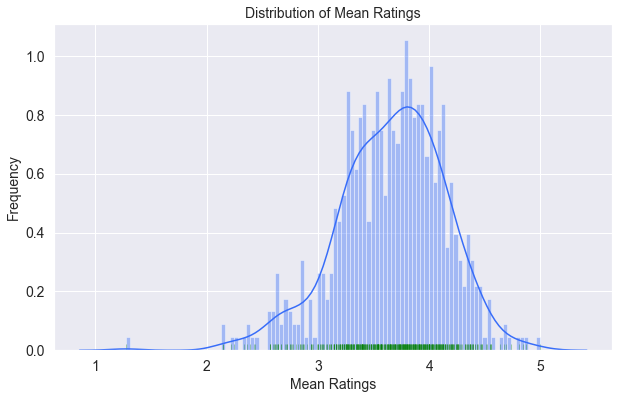

In [73]:
plt.figure(figsize=(10,6))
sns.distplot(means_byuser, bins=100, kde=True,rug_kws={'height': .02, 'alpha': .3, 'color':'green'}, rug=True)
plt.title('Distribution of Mean Ratings',fontsize=14)
plt.xlabel('Mean Ratings',fontsize=14 )
plt.ylabel('Frequency',fontsize=14 )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


In [74]:
print('The overall-mean of ratings is {} '.format(round(ratings['rating'].mean(),2)))
print('The mean of user-wise ratings is {} '.format(round(means_byuser.mean(),2)))

The overall-mean of ratings is 3.5 
The mean of user-wise ratings is 3.66 


The mean ratings are centered in the range 2.5 to 4.5

#### __Exploring genres:__
We can explore this feature to see movies in different categories. More specifically we can also segregate these movies according to user's preferred category. 

In [75]:
movies['genres'].head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

We need to convert this string into a list of individual elements.

In [76]:
movies['genres']=movies['genres'].apply(lambda x: x.split('|'))

__Now let's check the number of movies listed for each genres.__

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text yticklabel objects>)

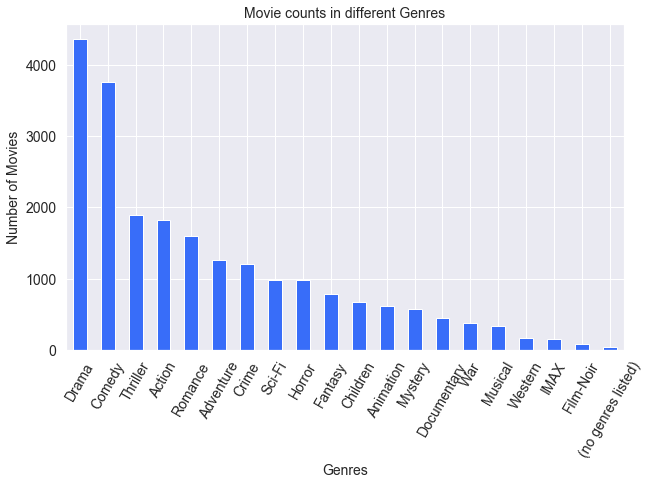

In [77]:
plt.figure(figsize=(10,6))
movies['genres'].apply(pd.Series).stack().reset_index(drop=True).value_counts().plot(kind='bar')
plt.title('Movie counts in different Genres',fontsize=14)
plt.xlabel('Genres',fontsize=14 )
plt.ylabel('Number of Movies',fontsize=14 )
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)

Let's also look into a genres, say 'comedy' and see the movies list in it.

In [78]:
movies[movies['genres'].apply(lambda x: 'Comedy' in x)].head(10)

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
6,7,Sabrina (1995),"[Comedy, Romance]"
10,11,"American President, The (1995)","[Comedy, Drama, Romance]"
11,12,Dracula: Dead and Loving It (1995),"[Comedy, Horror]"
17,18,Four Rooms (1995),[Comedy]
18,19,Ace Ventura: When Nature Calls (1995),[Comedy]
19,20,Money Train (1995),"[Action, Comedy, Crime, Drama, Thriller]"


Well, surely these are comedy movies. Still, this is a broad category. We can improve it by trying to find what types  of movies are generally liked by a user. 

lets merge movies and ratings.

In [79]:
ratings_movies=pd.merge(ratings, movies)

#### Viewer behaviour/ Movies as per user's likings.

Some insights about the viewer can be captured from this data. It's clear that the ratings given by the user reflects how he evaluates the movie. So an aggregate of rating of 5/4 for typical kinds of movies reflects user behaviour. This would reveal if the user likes more of comedy or romantic or action kinds of movies. 

We can find out the movie genres that the user tends to rate highest most of the time.

Let's take userId: 1 and analyse the genres this user has rated highest. For this we first find the maximum rating for that user and apply it as a condition to  filter out the genres. Then we assign it to variable liked_genres.

In [80]:
max_rating=ratings_movies[ratings_movies['userId']==1]['rating'].max()
liked_genres=ratings_movies[(ratings_movies['userId']==1) & (ratings_movies['rating']== max_rating)]['genres'].apply(pd.Series).stack().value_counts().index[0]
print('The viewer with userId 1 mostly gives high ratings to {} kinds of movies.'.format(liked_genres))


The viewer with userId 1 mostly gives high ratings to Adventure kinds of movies.


We can list down movies in the category most liked by user.

In [92]:
ratings_movies[(ratings_movies['userId']==1) & (ratings_movies['genres'].apply(lambda x : liked_genres in x))][['title', 'rating', 'genres']].sort_values(by='rating', ascending=False).head(10)
genres=ratings_movies[(ratings_movies['userId']==1) & (ratings_movies['genres'].apply(lambda x : liked_genres in x))][['title', 'rating', 'genres']].sort_values(by='rating', ascending=False).head(10)
genres.to_excel('gen.xlsx')

We have a fair idea about the user's behaviour and can recommend him according to his likes. However, in reality one does not stick to watching only one kind of movies. So, more about the user needs to be learnt. 

When it comes to recommending unseen movies, user's information may be scarcely available. This is why we need to apply collaborative filters and learn from other similar users.

#### Collaborative filtering


For getting similar user's data, we will take cosine similarities. We will use KNNBasic Model to learn the data and predict the ratings. The steps are:
We will create a Collab_user_wise Class with 5 functions, which can be called as methods to this class. The 5 functions are:

    a. Learn: KNNBasic Model from Surprise Library is used to train the dataset and data specific to a user is extracted.

    b. Evaluate: This function inputs userId and returns model metrics ie Root Mean Squared Error.
    
    c. Collaborative_recom: This function returns top 10 recommendations based on predicted rating. It is a user-based collaborative filtering. To ensure that the user is recommended trending movies we have 
    
    d. User_liked_genres: This is also a user based filtering. In addition, we have selected movies of genres that the user specifically likes based on past ratings. The list is then filtered based on weighted vote averages.
    
    e. Hybrid-recommendation: This recommendation is based on user-based and item based filtering.



In [82]:

from surprise import Reader, Dataset, KNNBasic
from sklearn.metrics import mean_squared_error

In [83]:
movies_chart=pd.read_csv('mod_movies.csv')

In [84]:

class Collab_user_wise():
    
    def learn(self, uid):
        """ Prepare data for estimation: This function inputs userId and prepares user specifuc dataset. """
        
        #create reader
        reader = Reader(rating_scale=(1, 5))
        #load data
        data = Dataset.load_from_df(ratings_movies[['userId', 'movieId', 'rating']], reader)
        #create trainset
        trainingset=data.build_full_trainset()
        #specify similarity parameter
        sim_options={'name':'cosine', 'user_based': True}
        #create model
        self.knn=KNNBasic(sim_options=sim_options)
        self.knn.fit(trainingset)
        #extract user data
        self.user_subset=ratings_movies[ratings_movies['userId']==uid]
        #update all movie ids and titles
        self.user_subset=pd.merge(self.user_subset, links[['movieId', 'tmdbId']], on='movieId', how='right')
        self.user_subset=self.user_subset.rename(columns={ 'tmdbId':'id'})
        self.user_subset=pd.merge(self.user_subset, movies, on='movieId', how='right')
        self.user_subset=self.user_subset.drop(['title_x', 'genres_x'], axis=1)
        self.user_subset=self.user_subset.rename(columns={'title_y': 'title', 'genres_y': 'genres'})
        self.user_subset['userId']=1
        #Create column to update status based on whether user has watched a movie        
        self.user_subset['watched_status']= np.where(self.user_subset['rating'].isnull(), 'unseen','seen')
        #Predict ratings
        self.user_subset['estimated_r']= self.user_subset['movieId'].apply(lambda x: self.knn.predict(uid, x).est )
    
    def evaluate(self,uid):
        """Evaluate the model.: This function inputs userId and returns the RMSE score on predictions"""
        
        evaluate_set=self.user_subset[self.user_subset['watched_status']=='seen']
        return np.sqrt(mean_squared_error(evaluate_set['rating'], evaluate_set['estimated_r'])).round(2)
       
    
    def collaborative_recom(self,uid):
        """Recommendation based on user-based filtering: This function inputs userId and returns top 10 recommended movies"""
       
        # Update the weighted vote score for the movies
        user_subset=pd.merge(self.user_subset, movies_chart[['id', 'wtd_vote_average']], on='id', how='left')
        # Select the movies that the user has not watched
        unseen=user_subset[user_subset['watched_status']=='unseen']
        #Get final recommendation based on weighted vote score
        return unseen[['title', 'estimated_r','watched_status','wtd_vote_average']].sort_values(by='wtd_vote_average', ascending=False).head(10)
    
    def user_liked_genres(self,uid):
        """Recommendation based on user based collaborative filtering and selection based on users highest rated genres: This function inputs the userId and returns top 10 recommended movies"""
        
        # Update the weighted vote score for the movies
        user_subset=pd.merge(self.user_subset, movies_chart[['id', 'wtd_vote_average']], on='id', how='left')
        # Maximum rating of the user
        max_rating=user_subset['rating'].max()
        # Get the genres which is rated highest by the user
        user_liked_genres=user_subset[user_subset['rating']== max_rating]['genres'].apply(pd.Series).stack().value_counts().index[0]
        # Extract the movies baed on the liked genres of user
        user_subset_genres=user_subset[user_subset['genres'].apply(lambda x: user_liked_genres in x )]
        # Select the movies that the user has not watched
        seen=user_subset_genres[user_subset_genres['watched_status']=='seen']
        #Get final recommendation based on weighted vote score
        return seen[['title', 'estimated_r','watched_status','wtd_vote_average', 'genres']].sort_values(by='wtd_vote_average', ascending=False).head(10)
        
    
    def user_liked_genres_recom(self,uid):
        """Recommendation based on user based collaborative filtering and selection based on users highest rated genres: This function inputs the userId and returns top 10 recommended movies"""
        
        # Update the weighted vote score for the movies
        user_subset=pd.merge(self.user_subset, movies_chart[['id', 'wtd_vote_average']], on='id', how='left')
        # Maximum rating of the user
        max_rating=user_subset['rating'].max()
        # Get the genres which is rated highest by the user
        user_liked_genres=user_subset[user_subset['rating']== max_rating]['genres'].apply(pd.Series).stack().value_counts().index[0]
        # Extract the movies baed on the liked genres of user
        user_subset_genres=user_subset[user_subset['genres'].apply(lambda x: user_liked_genres in x )]
        # Select the movies that the user has not watched
        unseen=user_subset_genres[user_subset_genres['watched_status']=='unseen']
        #Get final recommendation based on weighted vote score
        return unseen[['title', 'estimated_r','watched_status','wtd_vote_average', 'genres']].sort_values(by='wtd_vote_average', ascending=False).head(10)
        
            
    def hybrid_recomendation(self,uid,title):   
        """Recommendation based on user-based and item-based collaborative filtering: This function inputs userId and movie title and returns top 10 recommended movies"""
        
        #get the indices of similar movies
        idx=indices[title]
        sim_scores=list(enumerate(cosine_sim2[idx]))
        sim_scores=sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores=sim_scores[1:100]
        movie_indices=[ele[0] for ele in sim_scores]
        movies_subset= movies_chart.iloc[movie_indices]
                
        #update the weighted vote score of similar movies
        similar_movies=pd.merge(self.user_subset, movies_subset[['id', 'wtd_vote_average']], on='id', how='right')
        unseen=  similar_movies[  similar_movies['watched_status']=='unseen']
        return unseen[['title', 'watched_status','wtd_vote_average', 'estimated_r' ]].sort_values(by='estimated_r', ascending=False).head(10)

Now let's create a class object and use it to make recommendations for userId 1

In [85]:
collab=Collab_user_wise()

In [86]:
collab.learn(1)

Computing the cosine similarity matrix...
Done computing similarity matrix.


We use the evaluate method to compute RMSE on for the predictions

In [87]:
collab.evaluate(1)

1.01

Let's take a look at the 1st recommendation.

In [88]:
collab.collaborative_recom(1)

,title,estimated_r,watched_status,wtd_vote_average
491,"Shawshank Redemption, The (1994)",4.661920,unseen,7.848957
6710,"Dark Knight, The (2008)",4.550529,unseen,7.773928
7372,Inception (2010),4.399518,unseen,7.736436
8376,Interstellar (2014),4.276796,unseen,7.661015
847,"Godfather, The (1972)",4.461688,unseen,7.614489
4800,"Lord of the Rings: The Return of the King, The...",4.349618,unseen,7.550201
3639,"Lord of the Rings: The Fellowship of the Ring,...",4.224335,unseen,7.506091
8475,Guardians of the Galaxy (2014),4.188406,unseen,7.469945
4137,"Lord of the Rings: The Two Towers, The (2002)",4.250757,unseen,7.448945
8063,Django Unchained (2012),4.150001,unseen,7.404768


These unseen movies have a high prediction. The vote_average is also high for these movies. This factor needs to be taken into account to ensure that the recommended movies are good and vouched by the larger viewership.

Now let's get an idea of the movies and genres that the user has watched and rated high.

In [89]:
collab.user_liked_genres(1)

,title,estimated_r,watched_status,wtd_vote_average,genres
68,Star Wars: Episode V - The Empire Strikes Back...,4.387150,seen,7.481426,"[Action, Adventure, Sci-Fi]"
15,Star Wars: Episode IV - A New Hope (1977),4.487508,seen,7.468278,"[Action, Adventure, Sci-Fi]"
85,Back to the Future (1985),4.325501,seen,7.363861,"[Adventure, Comedy, Sci-Fi]"
219,Gladiator (2000),4.338125,seen,7.251699,"[Action, Adventure, Drama]"
73,Star Wars: Episode VI - Return of the Jedi (1983),4.474835,seen,7.186574,"[Action, Adventure, Sci-Fi]"
0,Toy Story (1995),4.074574,seen,7.111609,"[Adventure, Animation, Children, Comedy, Fantasy]"
26,Jurassic Park (1993),3.924782,seen,7.019334,"[Action, Adventure, Sci-Fi, Thriller]"
70,Raiders of the Lost Ark (Indiana Jones and the...,4.462776,seen,6.990842,"[Action, Adventure]"
89,Indiana Jones and the Last Crusade (1989),4.312545,seen,6.859540,"[Action, Adventure]"
67,Monty Python and the Holy Grail (1975),4.237858,seen,6.706293,"[Adventure, Comedy, Fantasy]"


We learnt already that the most highly rated genres for this user is 'Adventure'. So let's recommend movies on the basis of this genres to the user.

In [90]:
collab.user_liked_genres_recom(1)

,title,estimated_r,watched_status,wtd_vote_average,genres
4800,"Lord of the Rings: The Return of the King, The...",4.349618,unseen,7.550201,"[Action, Adventure, Drama, Fantasy]"
3639,"Lord of the Rings: The Fellowship of the Ring,...",4.224335,unseen,7.506091,"[Adventure, Fantasy]"
8475,Guardians of the Galaxy (2014),4.188406,unseen,7.469945,"[Action, Adventure, Sci-Fi]"
4137,"Lord of the Rings: The Two Towers, The (2002)",4.250757,unseen,7.448945,"[Adventure, Fantasy]"
8900,Inside Out (2015),3.905206,unseen,7.395734,"[Adventure, Animation, Children, Comedy, Drama..."
532,"Lion King, The (1994)",4.300535,unseen,7.310724,"[Adventure, Animation, Children, Drama, Musica..."
6772,WALL·E (2008),4.213624,unseen,7.243772,"[Adventure, Animation, Children, Romance, Sci-Fi]"
7768,"Dark Knight Rises, The (2012)",4.226304,unseen,7.222514,"[Action, Adventure, Crime, IMAX]"
7039,Up (2009),4.175605,unseen,7.206665,"[Adventure, Animation, Children, Drama]"
8879,The Martian (2015),4.062523,unseen,7.155205,"[Adventure, Drama, Sci-Fi]"


We have already learnt that the movie 'Gladiator' is liked by this user as it has been rated high. Now lets recommend movies that are similar to 'Gladiator' for the user, that have not been watched yet. 

In [91]:
collab.hybrid_recomendation(1,'Gladiator')

,title,watched_status,wtd_vote_average,estimated_r
13,Seven Samurai (Shichinin no samurai) (1954),unseen,6.564238,4.274562
6,Blade Runner (1982),unseen,7.060645,4.174557
51,Nebraska (2013),unseen,6.318144,4.120728
63,The Martian (2015),unseen,7.155205,4.062523
70,Shin Godzilla (2016),unseen,6.110151,4.000000
14,Raise the Titanic (1980),unseen,6.085694,4.000000
69,Ip Man 3 (2015),unseen,6.137060,4.000000
61,"Gunman, The (2015)",unseen,6.024217,4.000000
22,Nicholas Nickleby (2002),unseen,6.103046,4.000000
29,"Bourne Supremacy, The (2004)",unseen,6.625590,3.975706


Similarly, we can recommend movies similar to 'Jurassic Park', based on the ratings of similar users.